In [126]:
import pandas as pd
import numpy as np
import nannyml as nml
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from nannyml.drift.multivariate.data_reconstruction.result import Result

In [38]:
df = pd.read_csv('../data/01_raw/house-pricing.csv')

In [39]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [40]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [41]:
df["YrSold"].value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

In [42]:
def create_timestamp_column(df, column_name_year, column_name_month):
    df['timestamp'] = pd.to_datetime(df[column_name_year].astype(str) + '-' + df[column_name_month].astype(str), format='%Y-%m')
    
    return df

In [43]:
df = create_timestamp_column(df, column_name_year="YrSold", column_name_month="MoSold")

In [44]:
def filter_rows_by_years(df, years, months=None):
    filtered_df = df[df['timestamp'].dt.year.isin(years)]
    
    if months:
        filtered_df = filtered_df[filtered_df['timestamp'].dt.month.isin(months)]
    
    return filtered_df

In [45]:
df = df[["MSSubClass","MSZoning","LotFrontage","LotArea", "Street","timestamp","SalePrice"]]

In [46]:
median_sale_price = df["SalePrice"].median()
df['binarized'] = df["SalePrice"].apply(lambda x: 1 if x > median_sale_price else 0)

In [47]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,timestamp,SalePrice,binarized
0,60,RL,65.0,8450,Pave,2008-02-01,208500,1
1,20,RL,80.0,9600,Pave,2007-05-01,181500,1
2,60,RL,68.0,11250,Pave,2008-09-01,223500,1
3,70,RL,60.0,9550,Pave,2006-02-01,140000,0
4,60,RL,84.0,14260,Pave,2008-12-01,250000,1
...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,2007-08-01,175000,1
1456,20,RL,85.0,13175,Pave,2010-02-01,210000,1
1457,70,RL,66.0,9042,Pave,2010-05-01,266500,1
1458,20,RL,68.0,9717,Pave,2010-04-01,142125,0


In [88]:
reference = filter_rows_by_years(df, [2007, 2008])
analysis = filter_rows_by_years(df, [2009, 2010])

In [89]:
scaler = MinMaxScaler()

In [90]:
reference["proba_pred"] = scaler.fit_transform(X=np.array(reference["SalePrice"]).reshape(-1,1), y=reference["binarized"])

C:\Users\leoal\AppData\Local\Temp\ipykernel_16288\667280526.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [91]:
analysis["proba_pred"] = scaler.transform(X=np.array(analysis["SalePrice"]).reshape(-1,1))

C:\Users\leoal\AppData\Local\Temp\ipykernel_16288\2254347285.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [92]:
feature_column_names = ["MSSubClass",
                        "MSZoning",
                        "LotFrontage",
                        "LotArea",
                        "Street"
                        ]

In [93]:
def calculate_drift(reference, analysis, feature_column_names):  
    calc = nml.DataReconstructionDriftCalculator(column_names=feature_column_names,
                                                 timestamp_column_name='timestamp'
                                                 )
    calc.fit(reference)

    results = calc.calculate(analysis)

    return results

In [125]:
type(result_years)

nannyml.drift.multivariate.data_reconstruction.result.Result

In [94]:
result_years = calculate_drift(reference, analysis, feature_column_names)

In [95]:
display(result_years.filter(period='analysis').to_df())

chunk                                                          \
         key chunk_index start_index end_index start_date   end_date   
0     [0:50]           0           0        50 2009-01-01 2009-04-01   
1   [51:101]           1          51       101 2009-04-01 2009-05-01   
2  [102:152]           2         102       152 2009-05-01 2009-06-01   
3  [153:203]           3         153       203 2009-06-01 2009-07-01   
4  [204:254]           4         204       254 2009-07-01 2009-09-01   
5  [255:305]           5         255       305 2009-09-01 2009-11-01   
6  [306:356]           6         306       356 2009-11-01 2010-02-01   
7  [357:407]           7         357       407 2010-02-01 2010-04-01   
8  [408:458]           8         408       458 2010-04-01 2010-05-01   
9  [510:509]           9         459       512 2010-07-01 2010-07-01   

            reconstruction_error                                      \
     period       sampling_error     value upper_confidence_boundary   
0  analysis             0.112286  0.630272                  0.967130   
1  analysis             0.112286  0.778354                  1.115212   
2  analysis             0.112286  0.828765                  1.165624   
3  analysis             0.112286  0.791450                  1.128308   
4  analysis             0.112286  0.657601                  0.994460   
5  analysis             0.112286  0.787139                  1.123997   
6  analysis             0.112286  0.712281                  1.049140   
7  analysis             0.112286  0.716112                  1.052970   
8  analysis             0.112286  0.798214                  1.135072   
9  analysis             0.109123  1.106609                  1.433977   

                                                                    
  lower_confidence_boundary upper_threshold lower_threshold  alert  
0                  0.293413        1.056872        0.466109  False  
1                  0.441496        1.056872        0.466109  False  
2                  0.491907        1.056872        0.466109  False  
3                  0.454591        1.056872        0.466109  False  
4                  0.320743        1.056872        0.466109  False  
5                  0.450280        1.056872        0.466109  False  
6                  0.375423        1.056872        0.466109  False  
7                  0.379253        1.056872        0.466109  False  
8                  0.461355        1.056872        0.466109  False  
9                  0.779242        1.056872        0.466109   True

In [96]:
display(result_years.filter(period='reference').to_df())

chunk                                                          \
         key chunk_index start_index end_index start_date   end_date   
0     [0:62]           0           0        62 2007-01-01 2007-04-01   
1   [63:125]           1          63       125 2007-04-01 2007-06-01   
2  [126:188]           2         126       188 2007-06-01 2007-07-01   
3  [189:251]           3         189       251 2007-07-01 2007-08-01   
4  [252:314]           4         252       314 2007-08-01 2007-12-01   
5  [315:377]           5         315       377 2007-12-01 2008-04-01   
6  [378:440]           6         378       440 2008-04-01 2008-06-01   
7  [441:503]           7         441       503 2008-06-01 2008-07-01   
8  [504:566]           8         504       566 2008-07-01 2008-09-01   
9  [630:629]           9         567       632 2008-12-01 2008-12-01   

             reconstruction_error                                      \
      period       sampling_error     value upper_confidence_boundary   
0  reference             0.101028  0.607666                  0.910749   
1  reference             0.101028  0.809938                  1.113022   
2  reference             0.101028  0.922155                  1.225239   
3  reference             0.101028  0.735069                  1.038153   
4  reference             0.101028  0.660695                  0.963779   
5  reference             0.101028  0.830604                  1.133687   
6  reference             0.101028  0.702914                  1.005997   
7  reference             0.101028  0.655071                  0.958154   
8  reference             0.101028  0.863431                  1.166515   
9  reference             0.098705  0.827365                  1.123480   

                                                                    
  lower_confidence_boundary upper_threshold lower_threshold  alert  
0                  0.304582        1.056872        0.466109  False  
1                  0.506855        1.056872        0.466109  False  
2                  0.619072        1.056872        0.466109  False  
3                  0.431986        1.056872        0.466109  False  
4                  0.357612        1.056872        0.466109  False  
5                  0.527521        1.056872        0.466109  False  
6                  0.399830        1.056872        0.466109  False  
7                  0.351987        1.056872        0.466109  False  
8                  0.560348        1.056872        0.466109  False  
9                  0.531250        1.056872        0.466109  False

In [97]:
figure = result_years.plot()

figure.show()

In [98]:
imputer = SimpleImputer(strategy='mean')

In [101]:
imputer.fit(np.array(reference["LotFrontage"]).reshape(-1,1))

SimpleImputer()

In [103]:
LotFrontage = imputer.transform(np.array(reference["LotFrontage"]).reshape(-1,1))

In [105]:
reference["LotFrontage"] = LotFrontage

C:\Users\leoal\AppData\Local\Temp\ipykernel_16288\2329655065.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [106]:
reference.isnull().value_counts()

MSSubClass  MSZoning  LotFrontage  LotArea  Street  timestamp  SalePrice  binarized  proba_pred
False       False     False        False    False   False      False      False      False         633
dtype: int64

In [107]:
calc = nml.UnivariateDriftCalculator(

    column_names=["MSSubClass","MSZoning","LotFrontage","LotArea", "Street","timestamp","SalePrice"],

    treat_as_categorical=['binarized'],

    timestamp_column_name='timestamp',

    continuous_methods=['kolmogorov_smirnov', 'jensen_shannon'],

    categorical_methods=['chi2', 'jensen_shannon'],

)

calc.fit(reference)

results = calc.calculate(analysis)


figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='drift')

figure.show()

c:\Users\leoal\.virtualenvs\mlops-nova-project-5FFhJkaC\lib\site-packages\nannyml\base.py:299: FutureWarning:

The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`



In [108]:
figure = results.filter(column_names=results.categorical_column_names, methods=['chi2']).plot(kind='drift')

figure.show()

In [113]:
estimator = nml.DLE(

    feature_column_names=["MSSubClass","MSZoning","LotFrontage","LotArea", "Street"],

    y_pred='binarized',

    y_true='binarized',

    timestamp_column_name='timestamp',

    metrics=['rmse', 'rmsle'],

    tune_hyperparameters=False

)

estimator.fit(reference)

results = estimator.estimate(analysis)

display(results.filter(period='analysis').to_df())

display(results.filter(period='reference').to_df())

metric_fig = results.plot()

metric_fig.show()

c:\Users\leoal\.virtualenvs\mlops-nova-project-5FFhJkaC\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

c:\Users\leoal\.virtualenvs\mlops-nova-project-5FFhJkaC\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

c:\Users\leoal\.virtualenvs\mlops-nova-project-5FFhJkaC\lib\site-packages\nannyml\sampling_error\regression.py:191: RuntimeWarning:

invalid value encountered in double_scalars

c:\Users\leoal\.virtualenvs\mlops-nova-project-5FFhJkaC\lib\site-packages\nannyml\sampling_error\regression.py:230: RuntimeWarning:

invalid value encountered in double_scalars

c:\Users\leoal\.virtualenvs\mlops-nova-project-5FFhJkaC\lib\site-packages\nannyml\sampling_error\regression.py:191: RuntimeWarning:

invalid value encountered in double_scalars

c:\Users\leoal\.virtualenvs\mlops-nova-project-5FFhJkaC\lib\site-packages\nannyml\sampling_error\regression.py:230: RuntimeWarning:

invalid value encountered in do

chunk                                                          \
         key chunk_index start_index end_index start_date   end_date   
0     [0:50]           0           0        50 2009-01-01 2009-04-01   
1   [51:101]           1          51       101 2009-04-01 2009-05-01   
2  [102:152]           2         102       152 2009-05-01 2009-06-01   
3  [153:203]           3         153       203 2009-06-01 2009-07-01   
4  [204:254]           4         204       254 2009-07-01 2009-09-01   
5  [255:305]           5         255       305 2009-09-01 2009-11-01   
6  [306:356]           6         306       356 2009-11-01 2010-02-01   
7  [357:407]           7         357       407 2010-02-01 2010-04-01   
8  [408:458]           8         408       458 2010-04-01 2010-05-01   
9  [510:509]           9         459       512 2010-07-01 2010-07-01   

                      rmse                 ...                         \
     period sampling_error realized value  ... lower_threshold  alert   
0  analysis            NaN      0.0   0.0  ...             0.0  False   
1  analysis            NaN      0.0   0.0  ...             0.0  False   
2  analysis            NaN      0.0   0.0  ...             0.0  False   
3  analysis            NaN      0.0   0.0  ...             0.0  False   
4  analysis            NaN      0.0   0.0  ...             0.0  False   
5  analysis            NaN      0.0   0.0  ...             0.0  False   
6  analysis            NaN      0.0   0.0  ...             0.0  False   
7  analysis            NaN      0.0   0.0  ...             0.0  False   
8  analysis            NaN      0.0   0.0  ...             0.0  False   
9  analysis            NaN      0.0   0.0  ...             0.0  False   

           rmsle                                           \
  sampling_error realized value upper_confidence_boundary   
0            NaN      0.0   0.0                       NaN   
1            NaN      0.0   0.0                       NaN   
2            NaN      0.0   0.0                       NaN   
3            NaN      0.0   0.0                       NaN   
4            NaN      0.0   0.0                       NaN   
5            NaN      0.0   0.0                       NaN   
6            NaN      0.0   0.0                       NaN   
7            NaN      0.0   0.0                       NaN   
8            NaN      0.0   0.0                       NaN   
9            NaN      0.0   0.0                       NaN   

                                                                    
  lower_confidence_boundary upper_threshold lower_threshold  alert  
0                       0.0             0.0             0.0  False  
1                       0.0             0.0             0.0  False  
2                       0.0             0.0             0.0  False  
3                       0.0             0.0             0.0  False  
4                       0.0             0.0             0.0  False  
5                       0.0             0.0             0.0  False  
6                       0.0             0.0             0.0  False  
7                       0.0             0.0             0.0  False  
8                       0.0             0.0             0.0  False  
9                       0.0             0.0             0.0  False  

[10 rows x 23 columns]

chunk                                                          \
         key chunk_index start_index end_index start_date   end_date   
0     [0:62]           0           0        62 2007-01-01 2007-04-01   
1   [63:125]           1          63       125 2007-04-01 2007-06-01   
2  [126:188]           2         126       188 2007-06-01 2007-07-01   
3  [189:251]           3         189       251 2007-07-01 2007-08-01   
4  [252:314]           4         252       314 2007-08-01 2007-12-01   
5  [315:377]           5         315       377 2007-12-01 2008-04-01   
6  [378:440]           6         378       440 2008-04-01 2008-06-01   
7  [441:503]           7         441       503 2008-06-01 2008-07-01   
8  [504:566]           8         504       566 2008-07-01 2008-09-01   
9  [630:629]           9         567       632 2008-12-01 2008-12-01   

                       rmse                 ...                         \
      period sampling_error realized value  ... lower_threshold  alert   
0  reference            NaN      0.0   0.0  ...             0.0  False   
1  reference            NaN      0.0   0.0  ...             0.0  False   
2  reference            NaN      0.0   0.0  ...             0.0  False   
3  reference            NaN      0.0   0.0  ...             0.0  False   
4  reference            NaN      0.0   0.0  ...             0.0  False   
5  reference            NaN      0.0   0.0  ...             0.0  False   
6  reference            NaN      0.0   0.0  ...             0.0  False   
7  reference            NaN      0.0   0.0  ...             0.0  False   
8  reference            NaN      0.0   0.0  ...             0.0  False   
9  reference            NaN      0.0   0.0  ...             0.0  False   

           rmsle                                           \
  sampling_error realized value upper_confidence_boundary   
0            NaN      0.0   0.0                       NaN   
1            NaN      0.0   0.0                       NaN   
2            NaN      0.0   0.0                       NaN   
3            NaN      0.0   0.0                       NaN   
4            NaN      0.0   0.0                       NaN   
5            NaN      0.0   0.0                       NaN   
6            NaN      0.0   0.0                       NaN   
7            NaN      0.0   0.0                       NaN   
8            NaN      0.0   0.0                       NaN   
9            NaN      0.0   0.0                       NaN   

                                                                    
  lower_confidence_boundary upper_threshold lower_threshold  alert  
0                       0.0             0.0             0.0  False  
1                       0.0             0.0             0.0  False  
2                       0.0             0.0             0.0  False  
3                       0.0             0.0             0.0  False  
4                       0.0             0.0             0.0  False  
5                       0.0             0.0             0.0  False  
6                       0.0             0.0             0.0  False  
7                       0.0             0.0             0.0  False  
8                       0.0             0.0             0.0  False  
9                       0.0             0.0             0.0  False  

[10 rows x 23 columns]

## Code for PSI from Lab01 

In [114]:
numerical_features = reference.select_dtypes(exclude='object').columns.tolist()
categorical_features = analysis.select_dtypes(include='object').columns.tolist()

In [115]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables
    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values, same size as expected
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal
    Returns:
       psi_values: ndarray of psi values for each variable
    Author:
       Matthew Burke
       github.com/mwburke
       worksofchart.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable
        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into
        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input


        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

In [116]:
def calculate_psi_categorical(actual, expected):
    actual_perc = actual.value_counts()/len(actual)
    expected_perc = expected.value_counts()/len(expected)
    actual_classes = list(actual_perc.index) 
    expected_classes = list(expected_perc.index)
    PSI = 0
    classes = set(actual_classes + expected_classes)
    for c in classes:
        final_actual_perc = actual_perc[c] if c in actual_classes else 0.00001
        final_expected_perc = expected_perc[c] if c in expected_classes else 0.00001
        PSI += (final_actual_perc - final_expected_perc)*np.log(final_actual_perc/final_expected_perc)
    return PSI

In [122]:
numerical_features = ['MSSubClass', 'LotFrontage', 'LotArea', 'SalePrice', 'binarized', 'proba_pred']

C:\Users\leoal\AppData\Local\Temp\ipykernel_16288\2966103336.py:58: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.



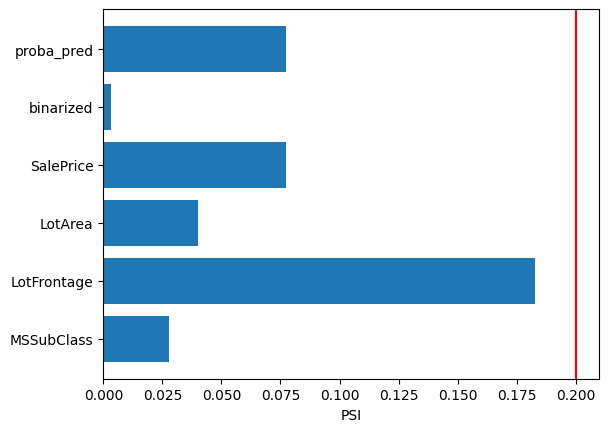

In [123]:
psis_num = []
#Using the github implementation to compute PSI's numerical features
for feature_name in numerical_features:
    psi = calculate_psi(reference[feature_name], analysis[feature_name], buckettype='bins', buckets=20, axis=0)
    psis_num.append(psi)
#Plot each feature's PSI value
height = psis_num
bars = numerical_features
y_pos = np.arange(len(bars))
plt.barh(y_pos, height)
plt.axvline(x=0.2,color='red')
plt.yticks(y_pos, bars)
plt.xlabel("PSI")
plt.show()